In [1]:
# Imports
import numpy as np
import pickle
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from skimage.metrics import structural_similarity as ssim

In [2]:
base = Path("..")  # adjust if needed

heat_dir = base / "data" / "heat_diffused_data"

npy_path = heat_dir / "visium_mouse_brain_pixel_gene_maps.npy"
genes_txt_path = heat_dir / "visium_mouse_brain_pixel_gene_maps_genes.txt"

ge_pixel_maps = np.load(npy_path)
print("ge_pixel_maps shape:", ge_pixel_maps.shape)

with open(genes_txt_path) as f:
    genes_for_pixels = [line.strip() for line in f]

print("Genes in order:", genes_for_pixels)
gene_to_idx = {g: i for i, g in enumerate(genes_for_pixels)}


ge_pixel_maps shape: (912, 880, 2)
Genes in order: ['Apoo', 'Agap2']


In [3]:
istar_dir = base / "data" / "istar_pickle_files"

def load_istar_gene(gene):
    p = istar_dir / f"{gene}.pickle"
    with open(p, "rb") as f:
        arr = pickle.load(f)
    arr = np.asarray(arr)
    print(gene, arr.shape)
    return arr


In [4]:
def min_max_norm(x):
    x = x.astype(float)
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    rng = x_max - x_min
    if rng <= 0:
        return np.zeros_like(x)
    return (x - x_min) / rng

def metrics_on_confident_region(heat_map, istar_map, frac=0.3):
    """
    Compare only in the top `frac` fraction of heat_map pixels (where diffusion is strongest).
    """
    h_flat = heat_map.ravel()

    # focus only on non-zero pixels
    nz = h_flat[h_flat > 0]
    if nz.size == 0:
        return np.nan, np.nan

    # threshold = e.g. top 30% of nonzero heat diffusion values
    thr = np.quantile(nz, 1 - frac)
    mask = heat_map >= thr

    h_sel = heat_map[mask]
    i_sel = istar_map[mask]

    # Spearman on confident region
    rho, _ = spearmanr(h_sel, i_sel)

    # SSIM on masked region: zero out everything else
    h_norm = min_max_norm(heat_map)
    i_norm = min_max_norm(istar_map)
    h_masked = np.where(mask, h_norm, 0)
    i_masked = np.where(mask, i_norm, 0)
    ssim_val = ssim(h_masked, i_masked, data_range=1.0)

    return rho, ssim_val


In [5]:
for gene in genes_for_pixels:
    heat_map = ge_pixel_maps[:, :, gene_to_idx[gene]]
    istar_map = load_istar_gene(gene)

    rho_conf, ssim_conf = metrics_on_confident_region(heat_map, istar_map, frac=0.3)
    print(f"{gene} – confident-region Spearman ρ = {rho_conf:.3f}, SSIM = {ssim_conf:.3f}")


Apoo (912, 880)
Apoo – confident-region Spearman ρ = 0.361, SSIM = 0.929
Agap2 (912, 880)
Agap2 – confident-region Spearman ρ = 0.318, SSIM = 0.939


In [6]:
def topk_overlap(heat_map, istar_map, k=0.05):
    """
    Jaccard/Dice overlap of top-k% high-expression pixels.
    """
    h_flat = heat_map.ravel()
    i_flat = istar_map.ravel()

    # thresholds at top k% for each method
    h_thr = np.quantile(h_flat, 1 - k)
    i_thr = np.quantile(i_flat, 1 - k)

    h_top = heat_map >= h_thr
    i_top = istar_map >= i_thr

    inter = np.logical_and(h_top, i_top).sum()
    union = np.logical_or(h_top, i_top).sum()
    jaccard = inter / union if union > 0 else np.nan
    dice = 2 * inter / (h_top.sum() + i_top.sum()) if (h_top.sum() + i_top.sum()) > 0 else np.nan

    return jaccard, dice


In [7]:
for gene in genes_for_pixels:
    heat_map = ge_pixel_maps[:, :, gene_to_idx[gene]]
    istar_map = load_istar_gene(gene)

    jacc, dice = topk_overlap(heat_map, istar_map, k=0.05)
    print(f"{gene} – Top-5% overlap: Jaccard = {jacc:.3f}, Dice = {dice:.3f}")


Apoo (912, 880)
Apoo – Top-5% overlap: Jaccard = 0.281, Dice = 0.438
Agap2 (912, 880)
Agap2 – Top-5% overlap: Jaccard = 0.290, Dice = 0.449


In [8]:
import matplotlib.pyplot as plt

def plot_with_contours(gene):
    idx = gene_to_idx[gene]
    heat_map = ge_pixel_maps[:, :, idx]
    istar_map = load_istar_gene(gene)

    # mask = top 30% of heat diffusion
    nz = heat_map[heat_map > 0]
    thr = np.quantile(nz, 0.7) if nz.size > 0 else np.inf
    mask = heat_map >= thr

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    im0 = ax[0].imshow(heat_map)
    ax[0].set_title(f"{gene} – Heat diffusion")
    ax[0].axis("off")
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(istar_map)
    ax[1].set_title(f"{gene} – iSTAR")
    ax[1].axis("off")
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(istar_map)
    ax[2].contour(mask, colors="red", linewidths=1)  # show where heat diffusion is strongest
    ax[2].set_title(f"{gene} – iSTAR with heat high-region (red)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

Apoo (912, 880)


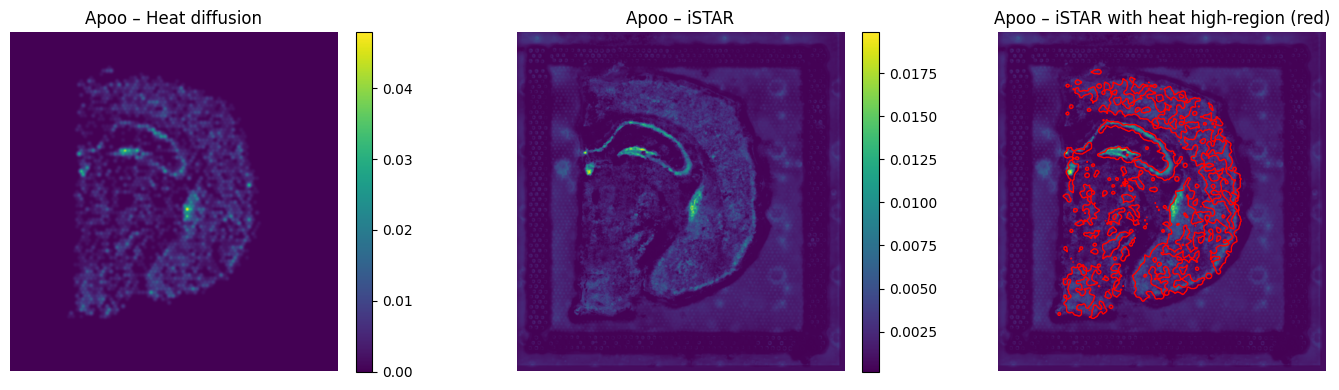

Agap2 (912, 880)


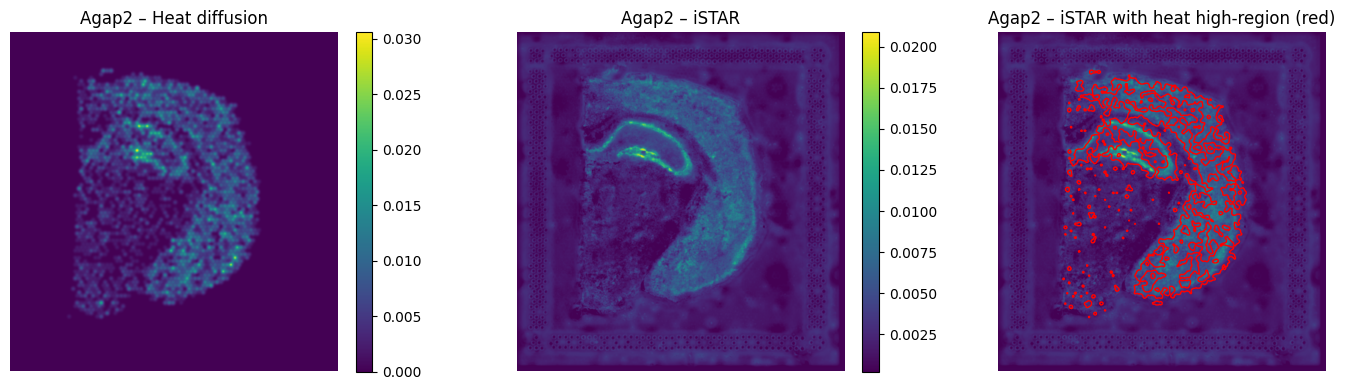

In [9]:
for g in genes_for_pixels:
    plot_with_contours(g)
